<a href="https://colab.research.google.com/github/piotr-malek/my_python_projects/blob/main/uhi_singapore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project I study urban heat islands (UHI) and how they retain temperature on the hottest days. I picked up Singapore as an example.

For starters I collected https://meteostat.net/ CSV files with the weather in Singapore 3 years back (the last record is from 18.11.2024), as recorded at Changi airport.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import datetime as dt
from google.colab import userdata
import requests

df1 = pd.read_csv('/content/drive/MyDrive/singapore_weather/2021.csv')
df2 = pd.read_csv('/content/drive/MyDrive/singapore_weather/2022.csv')
df3 = pd.read_csv('/content/drive/MyDrive/singapore_weather/2023.csv')
df4 = pd.read_csv('/content/drive/MyDrive/singapore_weather/2024.csv')

weather = pd.concat([df1, df2, df3, df4], ignore_index=True)
weather.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1096 non-null   object 
 1   tavg    1096 non-null   float64
 2   tmin    1096 non-null   float64
 3   tmax    1096 non-null   float64
 4   prcp    998 non-null    float64
 5   snow    0 non-null      float64
 6   wdir    1096 non-null   int64  
 7   wspd    1096 non-null   float64
 8   wpgt    0 non-null      float64
 9   pres    1096 non-null   float64
 10  tsun    0 non-null      float64
dtypes: float64(9), int64(1), object(1)
memory usage: 94.3+ KB


I'm interested in the hottest days so I picked the 10 days with the highest maximum temperature.

In [ ]:
top_temp = weather.sort_values(by='tavg', ascending=False).head(10)
top_temp

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
542,2023-05-13,30.7,27.7,35.0,0.4,NaN,125,10.7,NaN,1010.7,NaN
539,2023-05-10,30.6,28.7,33.5,0.4,NaN,150,16.9,NaN,1008.4,NaN
867,2024-04-02,30.6,28.0,34.1,1.2,NaN,85,11.1,NaN,1008.8,NaN
874,2024-04-09,30.6,27.6,35.0,7.0,NaN,350,12.2,NaN,1008.7,NaN
872,2024-04-07,30.5,27.7,34.6,0.4,NaN,17,14.7,NaN,1007.8,NaN
895,2024-04-30,30.5,28.6,32.7,0.6,NaN,119,9.7,NaN,1007.3,NaN
863,2024-03-29,30.5,28.0,35.0,0.1,NaN,57,14.3,NaN,1010.3,NaN
892,2024-04-27,30.5,28.2,33.5,3.2,NaN,67,9.1,NaN,1007.4,NaN
540,2023-05-11,30.4,28.7,33.1,5.1,NaN,129,15.2,NaN,1009.6,NaN
698,2023-10-16,30.4,28.1,33.0,4.3,NaN,198,8.8,NaN,1010.0,NaN


In [ ]:
weather['diurnal_range'] = weather['tmax'] - weather['tmin']
top_diurnal_dates = weather.nlargest(10, 'diurnal_range')['date']


In [ ]:
warmest_days = top_temp['date'].tolist()

Next, I prepared a function that calculates the 3 periods of time that matter from the UHI analysis perspective.
- peak heating where the temperatures usually are the highest. It occurs about 2-3 hours after solar noon.
- evening release occurs 2-4 hours after sunset. It's when we can typically observe the most significant temperature differwence between urban and rural areas.
- morning minimum is about 1 hour ahead of sunrise on the next day and is typically the minimum temperature recorded during the 24h cycle. It's when effects of UHI may still be present even though the sun has set many hours earlier.

In [ ]:
def uhi_timestamps(date, timezone, latitude, longitude):

    from datetime import datetime, time, timedelta
    from zoneinfo import ZoneInfo
    try:
      from suntime import Sun
    except ImportError:
      !pip install suntime
      from suntime import Sun

    date = datetime.strptime(date, "%Y-%m-%d").replace(tzinfo=ZoneInfo(timezone))

    sun = Sun(latitude, longitude)

    sunrise = sun.get_sunrise_time(date, date.tzinfo)
    sunset = sun.get_sunset_time(date + timedelta(days=1), date.tzinfo)
    sunrise_next_day = sun.get_sunrise_time(date + timedelta(days=1), date.tzinfo)

    peak_heating = sunrise + (sunset - sunrise)/2 + timedelta(hours=2, minutes=30)
    evening_release = sunset + timedelta(hours=3)
    morning_minimum = sunrise_next_day - timedelta(hours=1)

    return [peak_heating, evening_release, morning_minimum]

For each of the timestamps, I'll want to fetch the weather data to check if there are visible differences in retained temperature between industrial and green areas.

# OpenWeather API

OpenWeather API seemed like a good starting point. I ran a sample request to see what data is available.

In [ ]:
def get_weather_data(timestamp, latitude, longitude):

  url = 'https://api.openweathermap.org/data/3.0/onecall/timemachine'
  params = {
      'lat': latitude,
      'lon': longitude,
      'dt': timestamp,
      'units': 'metric',
      'appid': userdata.get('openweather_api_key')
  }

  data = requests.get(url, params=params).json()
  return data

data = get_weather_data(1653809526, 1.2818203269906308, 103.86410411878255)
data


{'lat': 1.2818,
 'lon': 103.8641,
 'timezone': 'Asia/Singapore',
 'timezone_offset': 28800,
 'data': [{'dt': 1653809526,
   'sunrise': 1653778588,
   'sunset': 1653822460,
   'temp': 33.55,
   'feels_like': 38.74,
   'pressure': 1006,
   'humidity': 54,
   'dew_point': 22.96,
   'clouds': 75,
   'visibility': 10000,
   'wind_speed': 4.12,
   'wind_deg': 210,
   'weather': [{'id': 803,
     'main': 'Clouds',
     'description': 'broken clouds',
     'icon': '04d'}]}]}

Next, I researched 8 locations around Singapore, splitting them into 2 buckets

*   green areas (natural reservoirs, forests, farmlands, etc.)
*   industrial areas (industrial zones, business districts with little to no green spaces)

In [ ]:
coordinates = [
    (1.2818203269906308, 103.86410411878255, "Gardens by the Bay", "Green area"),
    (1.3573088621408165, 103.81265865314295, "MacRitchie Reservoir", "Green area"),
    (1.3536353813490678, 103.77899403943894, "Bukit Timah Nature Reserve", "Green area"),
    (1.4328073219605584, 103.7112769013942, "Lim Chu Kang", "Green area"),
    (1.329024612107114, 103.64912374493152, "Tuas Industrial Estate", "Industrial area"),
    (1.3337406734525423, 103.74203240820238, "Jurong East", "Industrial area"),
    (1.2808989287421806, 103.85015500863199, "Raffles Place", "Industrial area"),
    (1.307343878223789, 103.6882436735534, "Jurong Island", "Industrial area")
]

And then I iterated through each of the dates selected earlier, and for each location and timestamp relevant to that date I pulled weather data.

In [ ]:
weather_data = []

for date in warmest_days:
    for lat, lon, location, area_type in coordinates:
        timestamps = uhi_timestamps(date, "Asia/Singapore", lat, lon)
        for t in timestamps:
            weather = get_weather_data(int(t.timestamp()), lat, lon)
            if 'data' in weather:
                if t == timestamps[0]:
                    period = "Peak heating"
                elif t == timestamps[1]:
                    period = "Evening release"
                elif t == timestamps[2]:
                    period = "Morning minimum"
                else:
                    period = "Unknown"

                weather_data.append({
                    'date': date,
                    'location': location,
                    'area_type': area_type,
                    'period': period,
                    'temp': weather['data'][0]['temp'],
                    'feels_like': weather['data'][0]['feels_like'],
                    'weather': weather['data'][0]['weather'][0]['description']
                })

df = pd.DataFrame(weather_data)
print(df)

           date              location        area_type           period  \
0    2022-05-29    Gardens by the Bay       Green area     Peak heating   
1    2022-05-29    Gardens by the Bay       Green area  Evening release   
2    2022-05-29    Gardens by the Bay       Green area  Morning minimum   
3    2022-05-29  MacRitchie Reservoir       Green area     Peak heating   
4    2022-05-29  MacRitchie Reservoir       Green area  Evening release   
..          ...                   ...              ...              ...   
235  2022-05-25         Raffles Place  Industrial area  Evening release   
236  2022-05-25         Raffles Place  Industrial area  Morning minimum   
237  2022-05-25         Jurong Island  Industrial area     Peak heating   
238  2022-05-25         Jurong Island  Industrial area  Evening release   
239  2022-05-25         Jurong Island  Industrial area  Morning minimum   

      temp  feels_like          weather  
0    33.55       38.74    broken clouds  
1    30.05     

With that data, I went on to check how temperatures drop in each of the analyzed areas. First I checked the difference in temperatures between peak_heating and evening_release.

In [ ]:
peak_heating_df = df[df['period'] == 'Peak heating']
evening_release_df = df[df['period'] == 'Evening release']
morning_minimum_df = df[df['period'] == 'Morning minimum']

peak_heating_pivot = peak_heating_df.pivot(index=['location', 'area_type'], columns='date', values='feels_like').sort_values(by='area_type')
evening_release_pivot = evening_release_df.pivot(index=['location', 'area_type'], columns='date', values='feels_like').sort_values(by='area_type')
morning_minimum_pivot = morning_minimum_df.pivot(index=['location', 'area_type'], columns='date', values='feels_like').sort_values(by='area_type')

evening_release_diff = (evening_release_pivot - peak_heating_pivot).sort_values(by='area_type')
evening_release_diff

,date,2022-05-12,2022-05-25,2022-05-29,2022-05-30,2023-05-13,2024-03-29,2024-04-04,2024-04-06,2024-04-07,2024-04-09
location,area_type,,,,,,,,,,
Bukit Timah Nature Reserve,Green area,-5.18,-1.03,-6.12,-2.89,0.06,-3.12,-9.48,-4.89,4.28,-4.60
Gardens by the Bay,Green area,-4.76,0.68,-6.40,-3.46,-0.94,-2.20,-3.02,-5.31,2.43,-5.26
Lim Chu Kang,Green area,0.94,-3.92,-1.19,-0.66,-1.03,-9.17,-4.97,-1.94,-7.28,-8.99
MacRitchie Reservoir,Green area,-5.36,0.26,-6.06,-3.06,0.33,-2.82,-5.18,-4.65,1.92,-4.17
Jurong East,Industrial area,-5.14,-4.10,-6.29,-2.53,0.74,-2.94,-7.64,-4.69,1.60,-3.68
Jurong Island,Industrial area,-3.07,-3.99,-5.04,-3.17,-3.47,-4.39,-5.59,-3.37,-3.17,-4.36
Raffles Place,Industrial area,-4.81,0.64,-6.17,-3.62,-1.21,-2.28,-2.93,-5.03,2.24,-5.05
Tuas Industrial Estate,Industrial area,-3.10,-4.01,-5.05,-3.16,-3.45,-4.37,-5.58,-3.34,-3.13,-4.34


Next, I looked how much heat is retained until the morning_minimum.

In [ ]:
morning_minimum_diff = (morning_minimum_pivot - peak_heating_pivot).sort_values(by='area_type')
morning_minimum_diff

,date,2022-05-12,2022-05-25,2022-05-29,2022-05-30,2023-05-13,2024-03-29,2024-04-04,2024-04-06,2024-04-07,2024-04-09
location,area_type,,,,,,,,,,
Bukit Timah Nature Reserve,Green area,-9.17,-1.76,-10.43,-5.54,-2.87,-9.55,-9.48,-6.98,4.32,-7.29
Gardens by the Bay,Green area,-8.64,-0.13,-8.12,-8.84,-4.40,-4.34,-3.11,-9.71,1.21,-9.40
Lim Chu Kang,Green area,-5.89,-3.68,-6.85,-5.82,-8.96,-11.12,-6.82,-4.41,-10.78,-12.85
MacRitchie Reservoir,Green area,-9.59,-0.48,-10.73,-6.59,-2.55,-6.27,-5.18,-7.56,1.57,-7.23
Jurong East,Industrial area,-7.34,-4.83,-7.40,-5.33,-2.03,-6.79,-7.64,-6.82,1.65,-6.53
Jurong Island,Industrial area,-9.96,-4.21,-8.02,-7.16,-5.87,-6.86,-6.80,-6.62,-6.16,-10.76
Raffles Place,Industrial area,-8.53,-0.16,-8.08,-8.78,-4.72,-4.73,-3.00,-9.23,1.19,-9.18
Tuas Industrial Estate,Industrial area,-10.00,-4.23,-8.01,-7.15,-5.83,-6.82,-6.79,-6.62,-6.14,-10.76


I also visualized the mean values for both area types to see if I can see any trends.

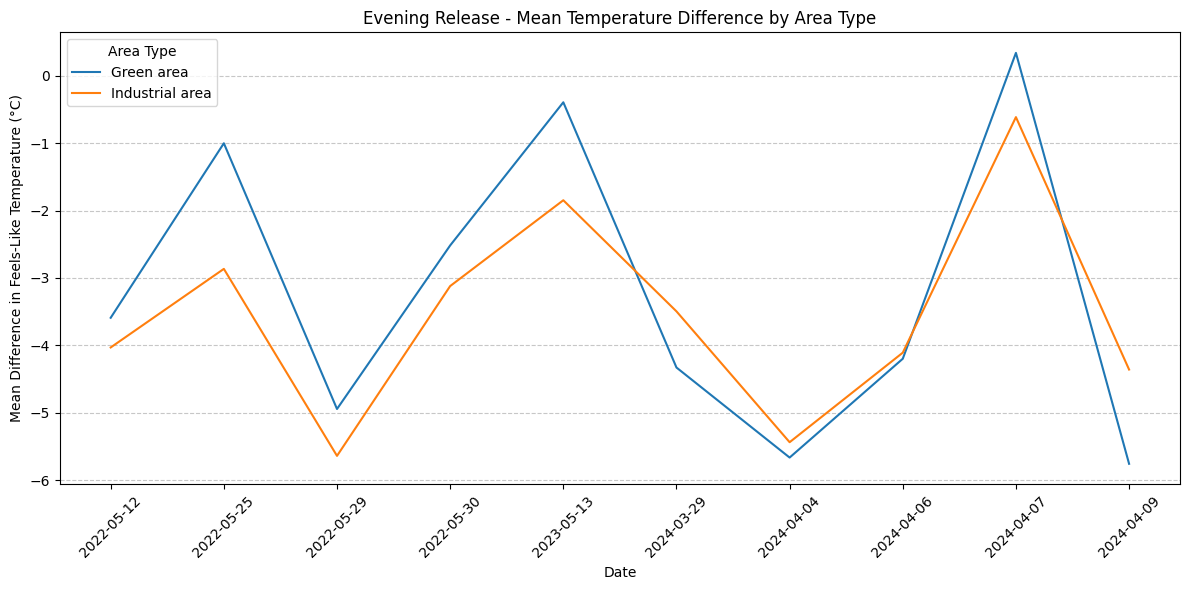

In [ ]:
import matplotlib.pyplot as plt

evening_release_mean = evening_release_diff.groupby(level='area_type').mean()
# Transpose for easier plotting (dates on x-axis)
evening_release_mean = evening_release_mean.T

plt.figure(figsize=(12, 6))
for area_type in evening_release_mean.columns:
    plt.plot(evening_release_mean.index, evening_release_mean[area_type], label=area_type)

plt.xlabel('Date')
plt.ylabel('Mean Difference in Feels-Like Temperature (°C)')
plt.title('Evening Release - Mean Temperature Difference by Area Type')
plt.legend(title='Area Type')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

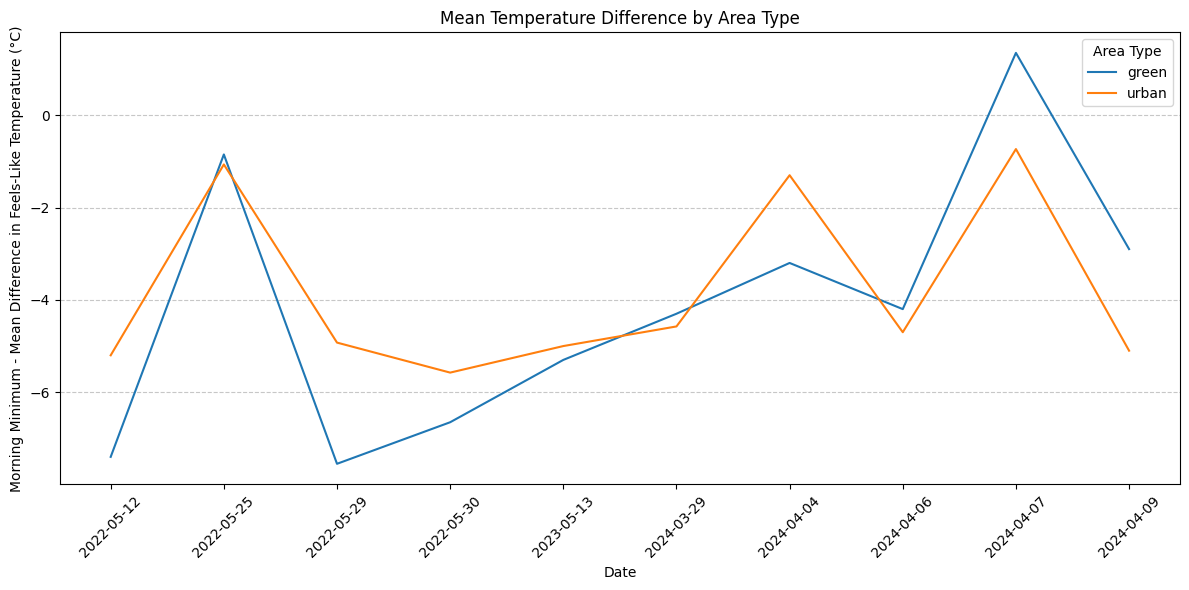

In [ ]:
morning_minimum_mean = morning_minimum_diff.groupby(level='area_type').mean()
morning_minimum_mean = morning_minimum_mean.T

plt.figure(figsize=(12, 6))
for area_type in morning_minimum_mean.columns:
    plt.plot(morning_minimum_mean.index, morning_minimum_mean[area_type], label=area_type)

plt.xlabel('Date')
plt.ylabel('Morning Minimum - Mean Difference in Feels-Like Temperature (°C)')
plt.title('Mean Temperature Difference by Area Type')
plt.legend(title='Area Type')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Some conclusions at this point:
- the results are more or less in line for both types of locations, making it impossible to see any effects of UHI
- no 2 days were the same even though the max temperatures on all 10 days analyzed were within 1.2 degress Celcius. On some days the temperatures even increased towards the evening and early morning for most locations.
- one exception is 'Lim Chu Kang' green area that tends to record lower temperatures but not always. Interestingly, 2 industrial areas (Jurong Island and Tuas Industrial Estate) also tend to show more significant drops.

I believe the culptir for such inconclusive data may be the API itself. OpenWeather API offers data for any pair of lat/lon but it doesn't mean they have stations there. Instead, they estimate temperatures (and other weather data) based on the readings from the nearby stations, some of which could be kilometers away. In such densely populated area, such readings can't provide any valuable information for my research.

I exported the data to BigQuery not to query the API over and over again should I need to analyze something more in the future.

In [ ]:
try:
    from google.cloud import bigquery
    from pandas_gbq import to_gbq
except ImportError:
    !pip install --upgrade google-cloud-bigquery pandas-gbq
    from google.cloud import bigquery
    from pandas_gbq import to_gbq

from google.colab import auth
auth.authenticate_user()

df['date'] = pd.to_datetime(df['date']).dt.date

project_id = "skilled-fulcrum-120820"
dataset_id = "openweather"
table_id = "singapore_hottest_days"

schema = [
    bigquery.SchemaField("date", "DATE"),
    bigquery.SchemaField("location", "STRING"),
    bigquery.SchemaField("area_type", "STRING"),
    bigquery.SchemaField("period", "STRING"),
    bigquery.SchemaField("temp", "FLOAT"),
    bigquery.SchemaField("feels_like", "FLOAT"),
    bigquery.SchemaField("weather", "STRING"),
]

client = bigquery.Client(project=project_id)
table_id = f"{project_id}.{dataset_id}.{table_id}"

job_config = bigquery.LoadJobConfig(schema=schema, write_disposition="WRITE_TRUNCATE")
job = client.load_table_from_dataframe(df, table_id, job_config=job_config)
job.result()

LoadJob<project=skilled-fulcrum-120820, location=US, id=719d09fb-ab46-4caa-bcbc-d9c5777aba7a>

# Weather data from Singapore open data API

Another idea was to tap into readings from specific stations. The government of Singapore offers a free API that also includes real-time and historical weather data.

Here's a sample request.

In [ ]:
import requests
import json

url = 'https://api.data.gov.sg/v1/environment/air-temperature'
dt = {'date_time':'2024-12-01T09:00:00'}

response = requests.get(url, params=dt)

data = response.json()
pretty_data = json.dumps(data, indent=4)
print(pretty_data)

{
    "metadata": {
        "stations": [
            {
                "id": "S109",
                "device_id": "S109",
                "name": "Ang Mo Kio Avenue 5",
                "location": {
                    "latitude": 1.3764,
                    "longitude": 103.8492
                }
            },
            {
                "id": "S117",
                "device_id": "S117",
                "name": "Banyan Road",
                "location": {
                    "latitude": 1.256,
                    "longitude": 103.679
                }
            },
            {
                "id": "S50",
                "device_id": "S50",
                "name": "Clementi Road",
                "location": {
                    "latitude": 1.3337,
                    "longitude": 103.7768
                }
            },
            {
                "id": "S107",
                "device_id": "S107",
                "name": "East Coast Parkway",
                "location": {


For starters, I wanted to obtain the list of weather stations along their coordinates. Technical or other issues may prevent stations from reporting at a specific hour so i went back 24 hours back and recorded all stations that had data on either of these periods.

In [ ]:
from datetime import datetime, timedelta

def fetch_station_coordinates(hours_back=24):
    base_url = "https://api.data.gov.sg/v1/environment/air-temperature"
    station_data = {}

    end_time = datetime.now()
    for delta in range(hours_back):
        query_time = end_time - timedelta(hours=delta)
        params = {'date_time': query_time.strftime('%Y-%m-%dT%H:%M:%S')}

        try:
            response = requests.get(base_url, params=params)
            if response.status_code == 200:
                data = response.json()
                stations = data.get('metadata', {}).get('stations', [])

                for station in stations:
                    station_id = station['id']
                    if station_id not in station_data:
                        station_data[station_id] = {
                            'name': station['name'],
                            'latitude': station['location']['latitude'],
                            'longitude': station['location']['longitude']
                        }
        except Exception as e:
            print(f"Error fetching data: {e}")

    return [(station_id,
             details['name'],
             details['latitude'],
             details['longitude'])
            for station_id, details in station_data.items()]

stations = fetch_station_coordinates()
for station_id, name, lat, lon in stations:
    print(f"ID: {station_id}, Name: {name}, Coordinates: ({lat}, {lon})")

ID: S109, Name: Ang Mo Kio Avenue 5, Coordinates: (1.3764, 103.8492)
ID: S117, Name: Banyan Road, Coordinates: (1.256, 103.679)
ID: S50, Name: Clementi Road, Coordinates: (1.3337, 103.7768)
ID: S107, Name: East Coast Parkway, Coordinates: (1.3135, 103.9625)
ID: S43, Name: Kim Chuan Road, Coordinates: (1.3399, 103.8878)
ID: S121, Name: Old Choa Chu Kang Road, Coordinates: (1.37288, 103.72244)
ID: S06, Name: Paya Lebar, Coordinates: (1.3524, 103.9007)
ID: S106, Name: Pulau Ubin, Coordinates: (1.4168, 103.9673)
ID: S111, Name: Scotts Road, Coordinates: (1.31055, 103.8365)
ID: S60, Name: Sentosa, Coordinates: (1.25, 103.8279)
ID: S24, Name: Upper Changi Road North, Coordinates: (1.3678, 103.9826)
ID: S116, Name: West Coast Highway, Coordinates: (1.281, 103.754)
ID: S104, Name: Woodlands Avenue 9, Coordinates: (1.44387, 103.78538)
ID: S115, Name: Tuas South Avenue 3, Coordinates: (1.29377, 103.61843)


I wanted to check whether any of these stations is anywhere close to the locations I previously checked.

In [ ]:
import pandas as pd
import math

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000 # Earth radius in meters
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

results = []
for loc_lat, loc_lon, loc_name, loc_area_type in coordinates:
    closest_station = None
    min_distance = float('inf')

    for station_id, station_name, station_lat, station_lon in stations:
        distance = haversine(loc_lat, loc_lon, station_lat, station_lon)
        if distance < min_distance:
            min_distance = distance
            closest_station = (station_id, station_name, station_lat, station_lon)

    results.append({
        "Location Name": loc_name,
        "Area Type": loc_area_type,
        "Closest Station ID": closest_station[0],
        "Closest Station Name": closest_station[1],
        "Station Coordinates": (closest_station[2], closest_station[3]),
        "Distance (meters)": min_distance
    })

results_df = pd.DataFrame(results)
print(results_df.head(8))

                Location Name        Area Type Closest Station ID  \
0          Gardens by the Bay       Green area               S111   
1        MacRitchie Reservoir       Green area               S109   
2  Bukit Timah Nature Reserve       Green area                S50   
3                Lim Chu Kang       Green area               S121   
4      Tuas Industrial Estate  Industrial area                S44   
5                 Jurong East  Industrial area                S50   
6               Raffles Place  Industrial area               S111   
7               Jurong Island  Industrial area                S44   

     Closest Station Name   Station Coordinates  Distance (meters)  
0             Scotts Road   (1.31055, 103.8365)        4429.679259  
1     Ang Mo Kio Avenue 5    (1.3764, 103.8492)        4583.311073  
2           Clementi Road    (1.3337, 103.7768)        2230.090674  
3  Old Choa Chu Kang Road  (1.37288, 103.72244)        6778.171291  
4          Nanyang Avenue  (1.345

Unfortunately, they're all quite far away. I opted to visualize both stations and locations to see if visual representation can be of any use.

In [ ]:
try:
  import folium
except ImportError:
  !pip install folium
  import folium

singapore_coords = [1.3521, 103.8198]
map_sg = folium.Map(location=singapore_coords, zoom_start=12)

for lat, lon, name, area_type in coordinates:
    folium.Marker(
        location=[lat, lon],
        popup=f"{name} ({area_type})",
        tooltip=name,
        icon=folium.Icon(color="green" if area_type == "Green area" else "blue"),
    ).add_to(map_sg)

for station_id, station_name, station_lat, station_lon in stations:
    folium.Marker(
        location=[station_lat, station_lon],
        popup=f"{station_name} (ID: {station_id})",
        tooltip=station_name,
        icon=folium.Icon(color="red", icon="cloud"),
    ).add_to(map_sg)

map_sg.save("singapore_map.html")

from google.colab import files
files.download("singapore_map.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

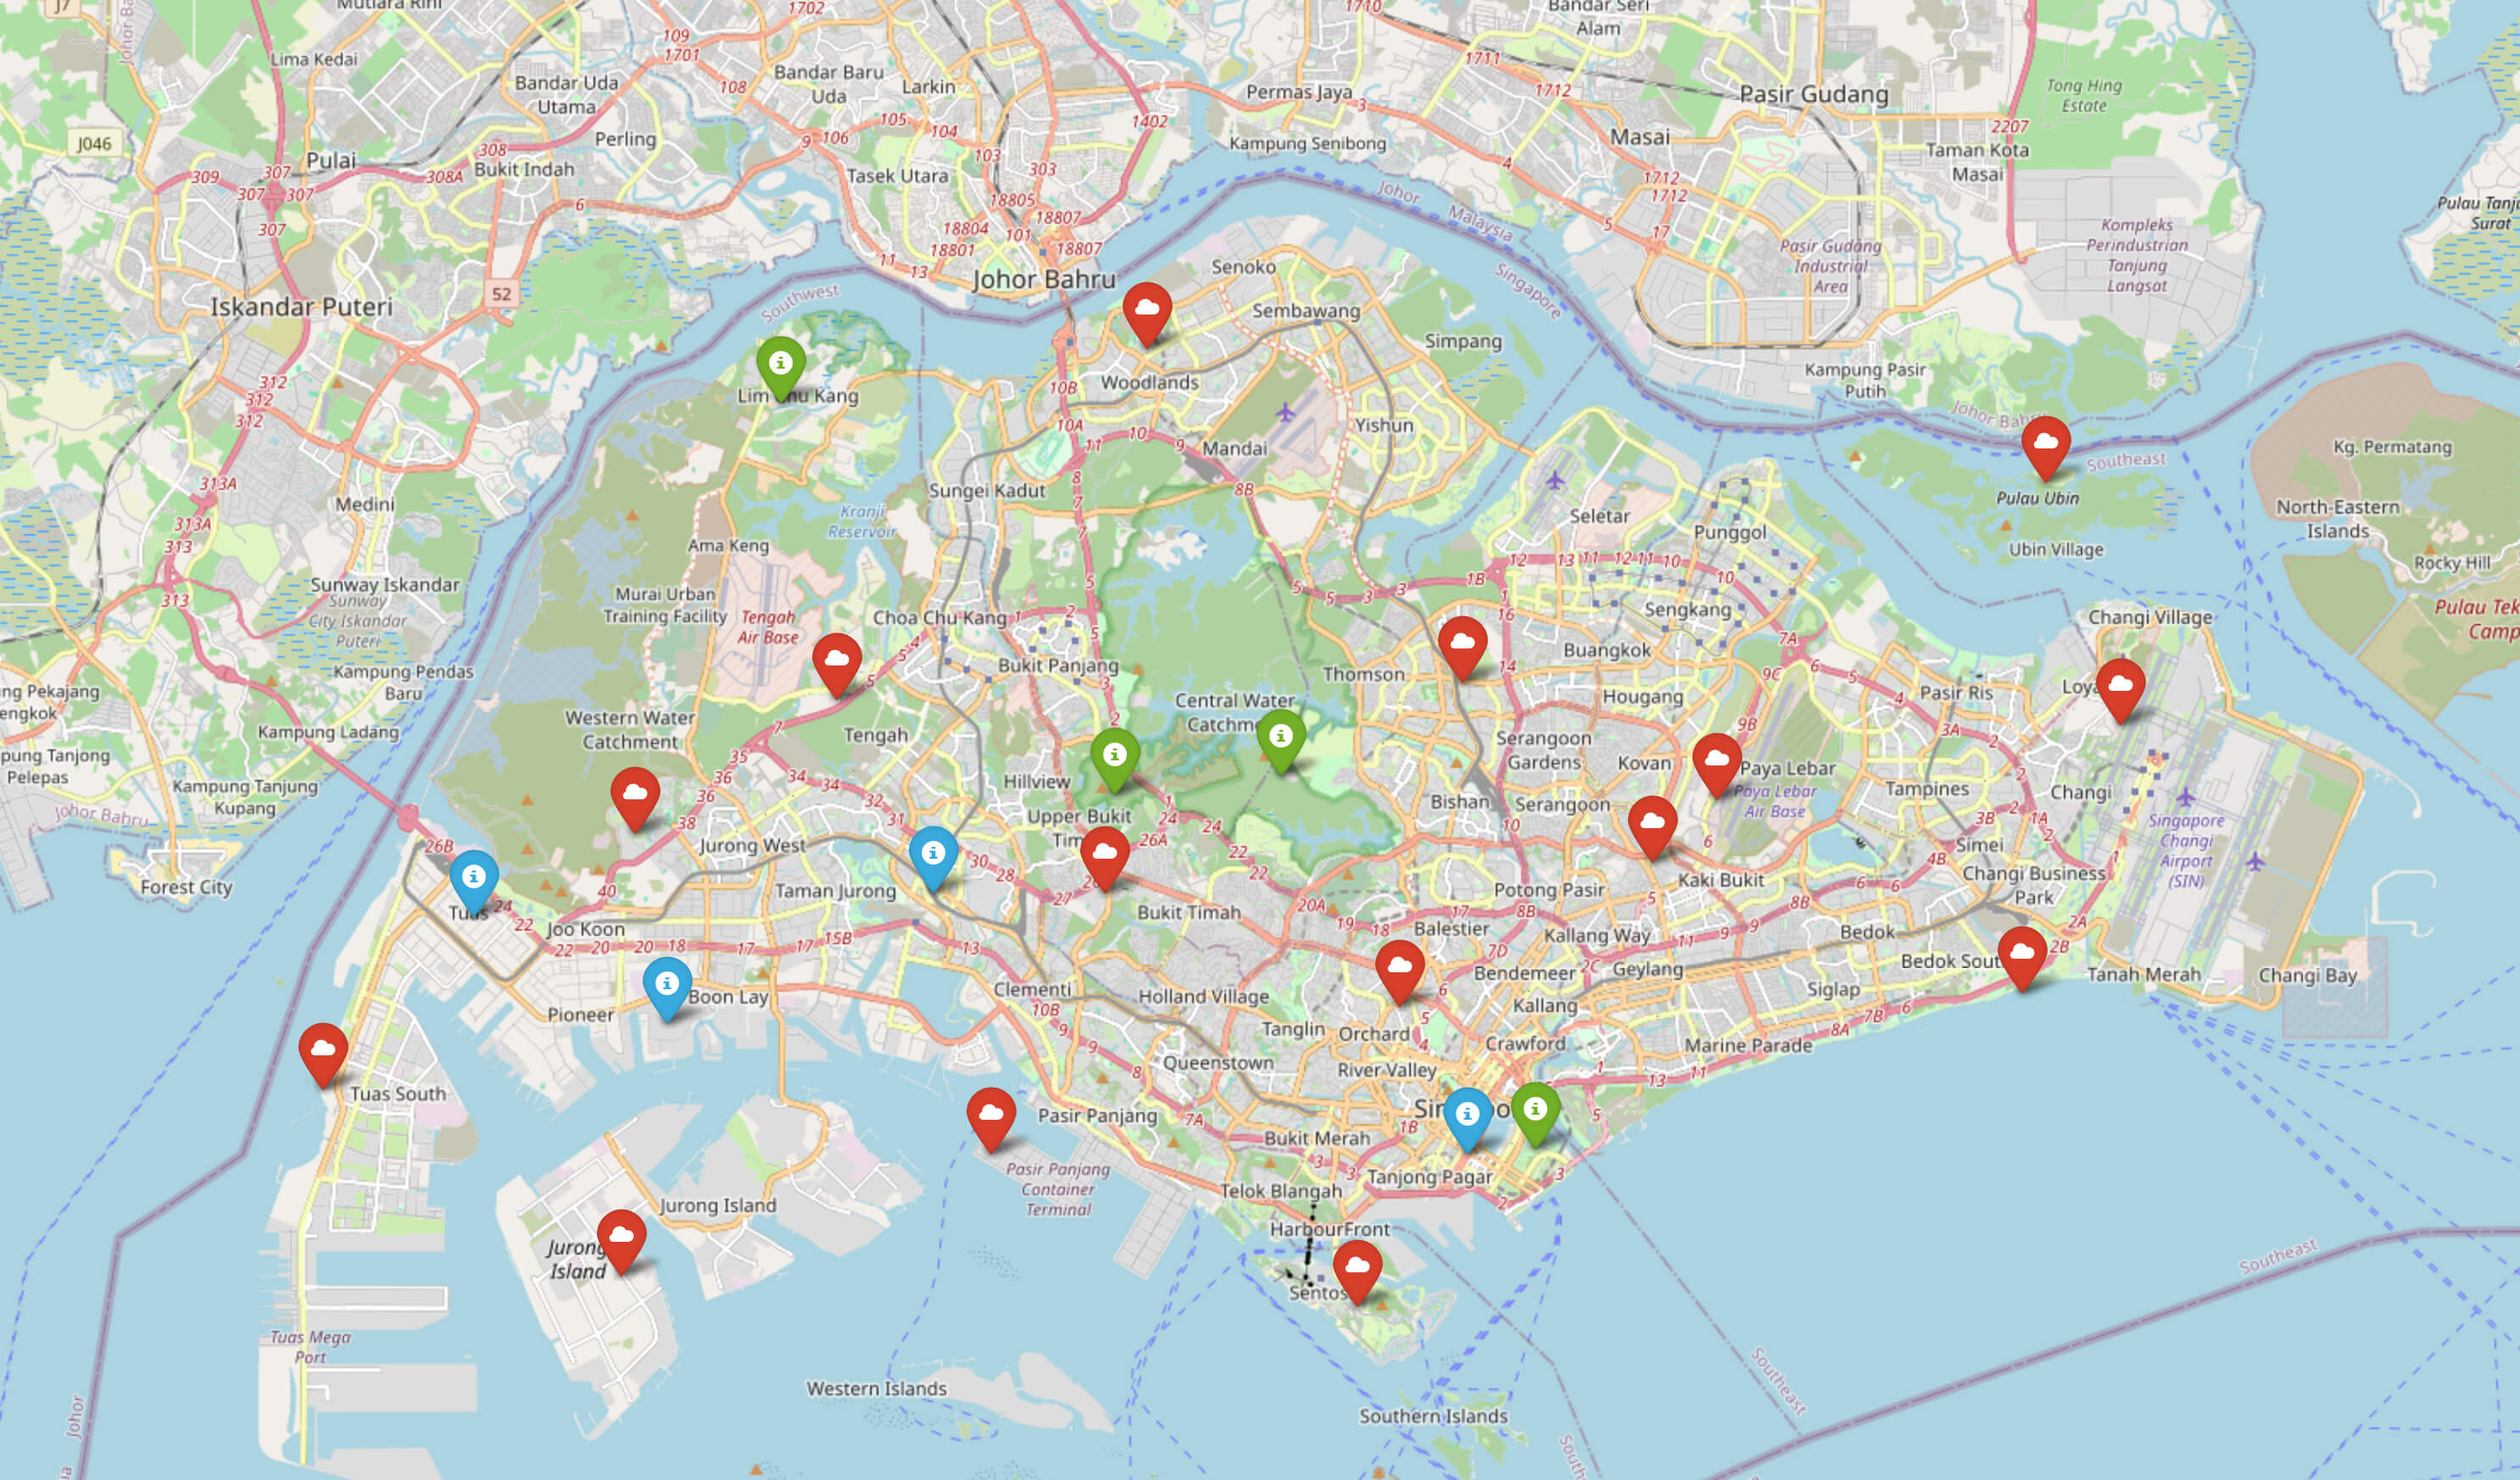

The map confirms that stations (red pins) are indeed far from green and industrial areas from my research (green and blue pins respectively).

But maybe it's worth tapping into data from some stations anyway. ChatGPT helped me determine stations that may be significant for my analysis:

Likely Relevant for Green Areas:
- S117, Banyan Road (1.256, 103.679): Near green spaces like Pasir Panjang. Useful for forested areas.
- S50, Clementi Road (1.3337, 103.7768): Near green corridors and campuses.
- S106, Pulau Ubin (1.4168, 103.9673): Surrounded by greenery. Could be ideal for studying the cooling in rural settings.
- S60, Sentosa (1.25, 103.8279): Coastal with park-like areas. Likely to show green area behavior.

Likely Relevant for Concrete Areas:
- S43, Kim Chuan Road (1.3399, 103.8878): Heavily urbanized and industrial area.
- S111, Scotts Road (1.31055, 103.8365): Dense commercial area. Reflects heat retention in high-density zones.
- S115, Tuas South Avenue 3 (1.29377, 103.61843): Industrial zone, representative of heat dynamics in heavy industrial areas.
- S121, Old Choa Chu Kang Road (1.37288, 103.72244): Fringe area transitioning from urban to green, useful as a comparison.



In [ ]:
green_stations = ['S117', 'S50', 'S106', 'S60']
urban_stations = ['S43', 'S111', 'S115', 'S121']

In [ ]:
import pandas as pd
from datetime import datetime

def fetch_temperature_data(date_time):

    dt = datetime.fromisoformat(str(date_time)).strftime('%Y-%m-%dT%H:%M:%S')

    station_data = []
    url = 'https://api.data.gov.sg/v1/environment/air-temperature'
    data = requests.get(url, params={'date_time': dt}).json()

    station_metadata = {station['id']: station['name'] for station in data.get('metadata', {}).get('stations', [])}

    readings = data.get('items', [{}])[0].get('readings', [])
    for station in readings:
        station_id = station['station_id']
        if station_id not in green_stations and station_id not in urban_stations:
            continue

        area_type = 'green' if station_id in green_stations else 'urban'

        station_data.append({
            'station_id': station_id,
            'name': station_metadata.get(station_id, 'Unknown'),
            'temperature': station['value'],
            'area_type': area_type
        })

    return station_data

In [ ]:
import pandas as pd

all_data = []

for date in warmest_days:
    timestamps = uhi_timestamps(date, "Asia/Singapore", 1.3521, 103.8198)

    for t in timestamps:
        station_data = fetch_temperature_data(t)

        station_df = pd.DataFrame(station_data)

        station_df['date'] = date

        if t == timestamps[0]:
            period = "Peak heating"
        elif t == timestamps[1]:
            period = "Evening release"
        elif t == timestamps[2]:
            period = "Morning minimum"
        else:
            period = "Unknown"

        station_df['period'] = period
        all_data.append(station_df)

weather = pd.concat(all_data, ignore_index=True)

print(weather.head(10))

  station_id                    name  temperature area_type        date  \
0        S50           Clementi Road         34.5     green  2022-05-29   
1        S43          Kim Chuan Road         33.9     urban  2022-05-29   
2       S121  Old Choa Chu Kang Road         33.5     urban  2022-05-29   
3       S106              Pulau Ubin         33.9     green  2022-05-29   
4       S111             Scotts Road         32.7     urban  2022-05-29   
5       S115     Tuas South Avenue 3         31.4     urban  2022-05-29   
6        S50           Clementi Road         30.1     green  2022-05-29   
7        S43          Kim Chuan Road         30.7     urban  2022-05-29   
8       S121  Old Choa Chu Kang Road         28.5     urban  2022-05-29   
9       S106              Pulau Ubin         26.6     green  2022-05-29   

            period  
0     Peak heating  
1     Peak heating  
2     Peak heating  
3     Peak heating  
4     Peak heating  
5     Peak heating  
6  Evening release  
7  Eve

In [ ]:
peak_heating_df = weather[weather['period'] == 'Peak heating']
evening_release_df = weather[weather['period'] == 'Evening release']
morning_minimum_df = weather[weather['period'] == 'Morning minimum']

peak_heating_pivot = peak_heating_df.pivot(index=['name', 'area_type'], columns='date', values='temperature').sort_values(by='area_type')
evening_release_pivot = evening_release_df.pivot(index=['name', 'area_type'], columns='date', values='temperature').sort_values(by='area_type')
morning_minimum_pivot = morning_minimum_df.pivot(index=['name', 'area_type'], columns='date', values='temperature').sort_values(by='area_type')

evening_release_diff = (evening_release_pivot - peak_heating_pivot).sort_values(by='area_type')
evening_release_diff

,date,2022-05-12,2022-05-25,2022-05-29,2022-05-30,2023-05-13,2024-03-29,2024-04-04,2024-04-06,2024-04-07,2024-04-09
name,area_type,,,,,,,,,,
Banyan Road,green,NaN,NaN,NaN,NaN,-2.8,-2.4,-2.1,-1.3,3.6,2.8
Clementi Road,green,-4.7,-0.9,-4.4,-5.5,-3.8,-3.9,-2.8,-4.7,0.0,-5.2
Pulau Ubin,green,-6.3,1.9,-7.3,-4.0,-6.4,NaN,NaN,NaN,NaN,NaN
Sentosa,green,NaN,NaN,NaN,NaN,-3.3,NaN,-2.5,NaN,NaN,-1.4
Kim Chuan Road,urban,-4.9,-0.5,-3.2,-5.0,-3.3,-4.3,2.2,-3.6,1.1,-4.6
Old Choa Chu Kang Road,urban,-4.0,-0.8,-5.0,-4.5,-4.5,-4.2,-3.7,-5.1,-1.3,-3.4
Scotts Road,urban,-3.6,-1.0,-2.7,-3.7,-3.2,-2.4,0.4,-2.6,-1.0,-3.5
Tuas South Avenue 3,urban,-1.3,NaN,-0.5,-2.1,-3.0,-3.1,-2.3,-2.5,1.9,-1.2


In [ ]:
morning_minimum_diff = (morning_minimum_pivot - peak_heating_pivot).sort_values(by='area_type')
morning_minimum_diff

,date,2022-05-12,2022-05-25,2022-05-29,2022-05-30,2023-05-13,2024-03-29,2024-04-04,2024-04-06,2024-04-07,2024-04-09
name,area_type,,,,,,,,,,
Banyan Road,green,NaN,NaN,NaN,NaN,-4.1,-3.5,-3.7,-2.4,3.2,0.8
Clementi Road,green,-6.7,-1.4,-7.1,-7.0,-5.2,-5.1,-2.8,-6.0,-0.5,-6.6
Pulau Ubin,green,-8.1,-0.3,-8.0,-6.3,-7.3,NaN,NaN,NaN,NaN,NaN
Sentosa,green,NaN,NaN,NaN,NaN,-4.6,NaN,-3.1,NaN,NaN,-2.9
Kim Chuan Road,urban,-5.3,-0.5,-5.7,-6.8,-4.6,-5.2,2.3,-4.8,0.9,NaN
Old Choa Chu Kang Road,urban,-5.9,-1.8,-6.4,-6.1,-6.6,-5.7,-4.8,-6.5,-1.8,-5.1
Scotts Road,urban,-5.8,-0.9,-4.4,-5.4,-4.3,-3.3,-0.1,-3.4,-1.3,-5.1
Tuas South Avenue 3,urban,-3.8,NaN,-3.2,-4.0,-4.5,-4.1,-2.6,-4.1,NaN,NaN


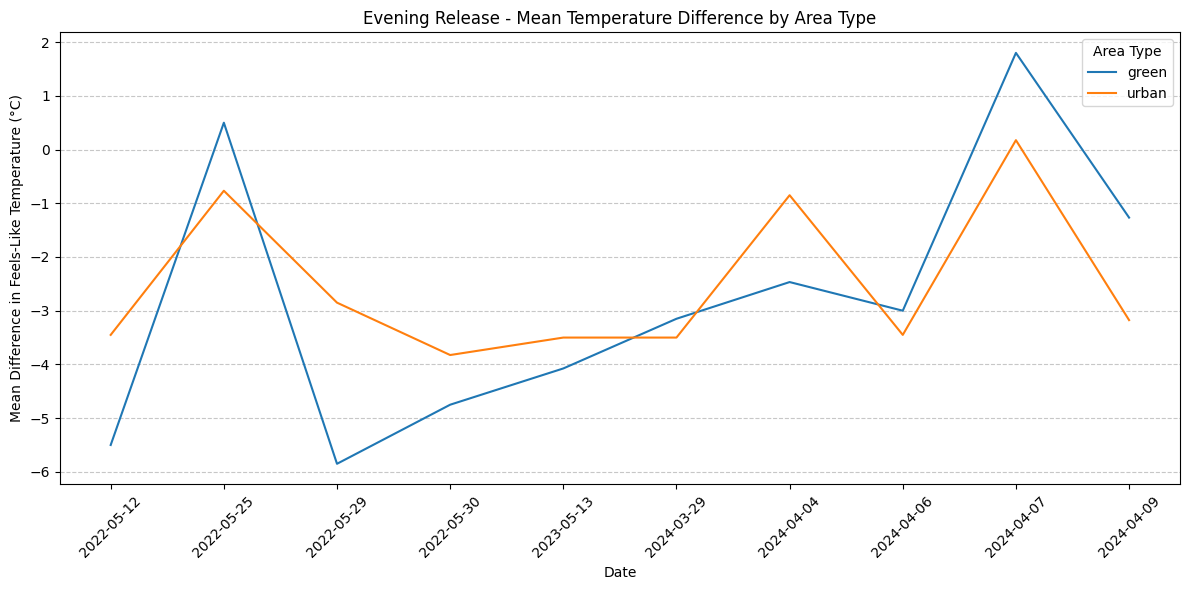

In [ ]:
import matplotlib.pyplot as plt

evening_release_mean = evening_release_diff.groupby(level='area_type').mean()
# Transpose for easier plotting (dates on x-axis)
evening_release_mean = evening_release_mean.T

plt.figure(figsize=(12, 6))
for area_type in evening_release_mean.columns:
    plt.plot(evening_release_mean.index, evening_release_mean[area_type], label=area_type)

plt.xlabel('Date')
plt.ylabel('Mean Difference in Feels-Like Temperature (°C)')
plt.title('Evening Release - Mean Temperature Difference by Area Type')
plt.legend(title='Area Type')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

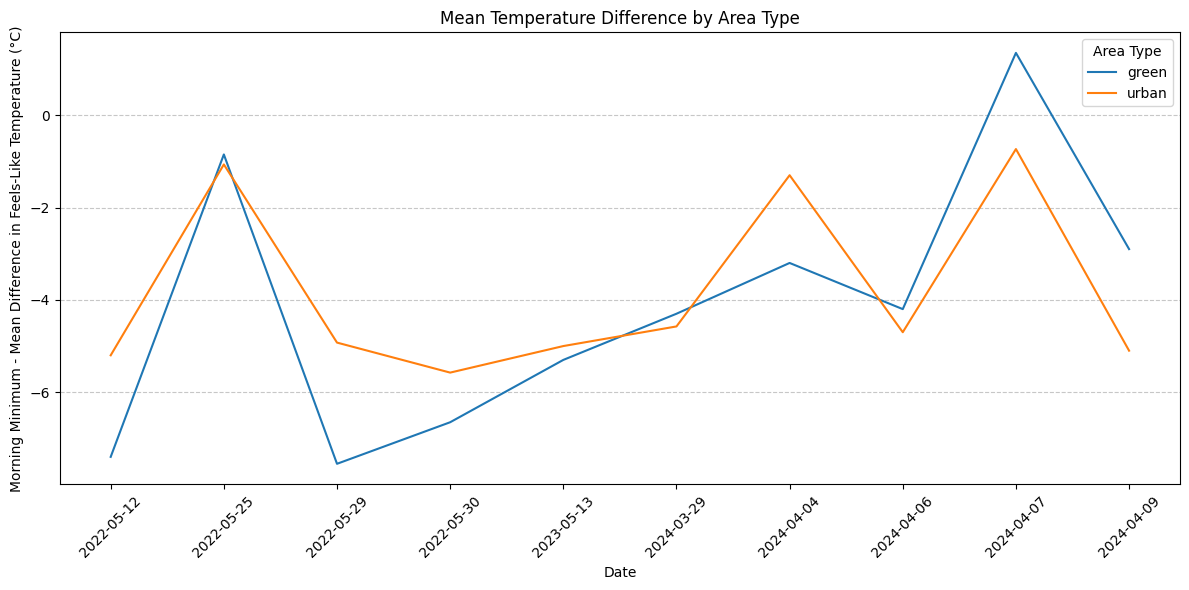

In [ ]:
morning_minimum_mean = morning_minimum_diff.groupby(level='area_type').mean()
morning_minimum_mean = morning_minimum_mean.T

plt.figure(figsize=(12, 6))
for area_type in morning_minimum_mean.columns:
    plt.plot(morning_minimum_mean.index, morning_minimum_mean[area_type], label=area_type)

plt.xlabel('Date')
plt.ylabel('Morning Minimum - Mean Difference in Feels-Like Temperature (°C)')
plt.title('Mean Temperature Difference by Area Type')
plt.legend(title='Area Type')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

all_data = []

for date in top_diurnal_dates:
    timestamps = uhi_timestamps(date, "Asia/Singapore", 1.3521, 103.8198)

    for t in timestamps:
        station_data = fetch_temperature_data(t)

        station_df = pd.DataFrame(station_data)

        station_df['date'] = date

        if t == timestamps[0]:
            period = "Peak heating"
        elif t == timestamps[1]:
            period = "Evening release"
        elif t == timestamps[2]:
            period = "Morning minimum"
        else:
            period = "Unknown"

        station_df['period'] = period
        all_data.append(station_df)

weather = pd.concat(all_data, ignore_index=True)

print(weather.head(10))

  station_id                    name  temperature area_type        date  \
0        S50           Clementi Road         32.0     green  2022-04-22   
1        S43          Kim Chuan Road         32.2     urban  2022-04-22   
2       S121  Old Choa Chu Kang Road         31.9     urban  2022-04-22   
3       S106              Pulau Ubin         32.1     green  2022-04-22   
4       S111             Scotts Road         31.0     urban  2022-04-22   
5       S115     Tuas South Avenue 3         31.7     urban  2022-04-22   
6        S50           Clementi Road         28.3     green  2022-04-22   
7        S43          Kim Chuan Road         28.8     urban  2022-04-22   
8       S121  Old Choa Chu Kang Road         28.6     urban  2022-04-22   
9       S106              Pulau Ubin         27.2     green  2022-04-22   

            period  
0     Peak heating  
1     Peak heating  
2     Peak heating  
3     Peak heating  
4     Peak heating  
5     Peak heating  
6  Evening release  
7  Eve

In [ ]:
peak_heating_df = weather[weather['period'] == 'Peak heating']
evening_release_df = weather[weather['period'] == 'Evening release']
morning_minimum_df = weather[weather['period'] == 'Morning minimum']

peak_heating_pivot = peak_heating_df.pivot(index=['name', 'area_type'], columns='date', values='temperature').sort_values(by='area_type')
evening_release_pivot = evening_release_df.pivot(index=['name', 'area_type'], columns='date', values='temperature').sort_values(by='area_type')
morning_minimum_pivot = morning_minimum_df.pivot(index=['name', 'area_type'], columns='date', values='temperature').sort_values(by='area_type')

evening_release_diff = (evening_release_pivot - peak_heating_pivot).sort_values(by='area_type')
morning_minimum_diff = (morning_minimum_pivot - peak_heating_pivot).sort_values(by='area_type')

,date,2022-03-21,2022-04-20,2022-04-22,2022-05-25,2022-06-08,2022-06-11,2022-07-21,2022-09-30,2022-10-02,2022-11-30
name,area_type,,,,,,,,,,
Clementi Road,green,-1.8,-3.6,-3.7,-0.9,-3.6,-2.3,-3.0,-3.5,-6.0,-3.5
Pulau Ubin,green,-3.7,-4.2,-4.9,1.9,-5.8,1.7,-4.7,-5.4,-5.8,-6.2
Sentosa,green,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.3,-2.8,-5.7
Kim Chuan Road,urban,-3.1,-3.4,-3.4,-0.5,-4.7,-3.1,-2.6,-2.5,-4.8,-4.1
Old Choa Chu Kang Road,urban,-3.0,-7.3,-3.3,-0.8,-7.7,-3.0,-3.4,-4.4,-5.1,-1.1
Scotts Road,urban,-1.7,-3.5,-2.8,-1.0,-6.4,-3.1,NaN,-2.8,-5.7,-2.4
Tuas South Avenue 3,urban,-1.3,-2.1,-2.2,NaN,NaN,-1.7,-2.1,-2.9,-1.4,-4.6


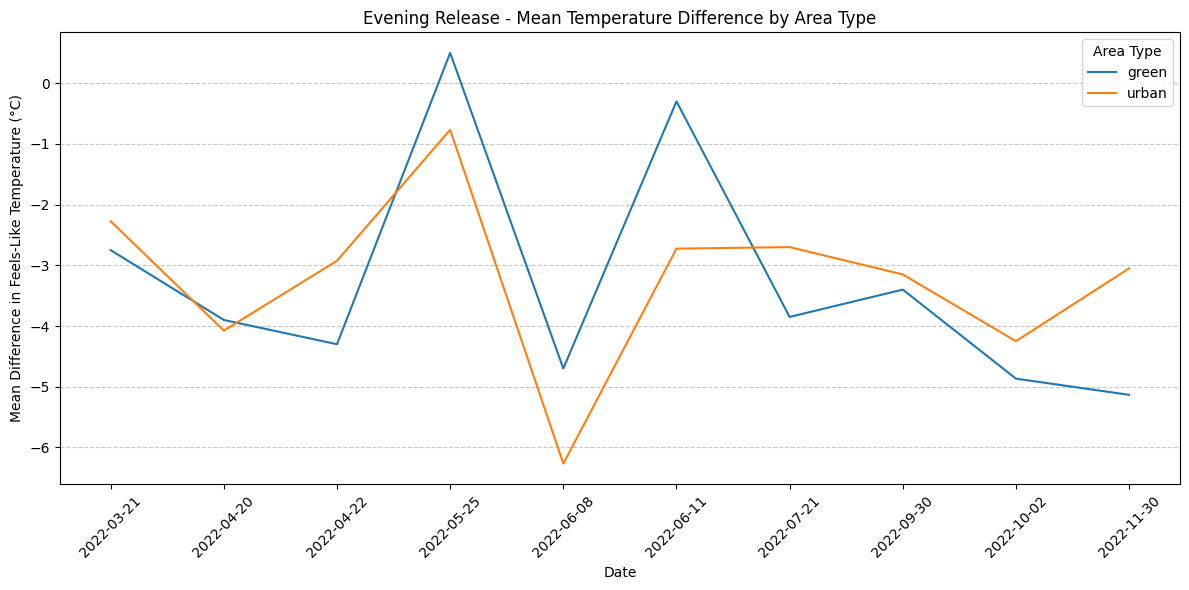

In [ ]:
import matplotlib.pyplot as plt

evening_release_mean = evening_release_diff.groupby(level='area_type').mean()
# Transpose for easier plotting (dates on x-axis)
evening_release_mean = evening_release_mean.T

plt.figure(figsize=(12, 6))
for area_type in evening_release_mean.columns:
    plt.plot(evening_release_mean.index, evening_release_mean[area_type], label=area_type)

plt.xlabel('Date')
plt.ylabel('Mean Difference in Feels-Like Temperature (°C)')
plt.title('Evening Release - Mean Temperature Difference by Area Type')
plt.legend(title='Area Type')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

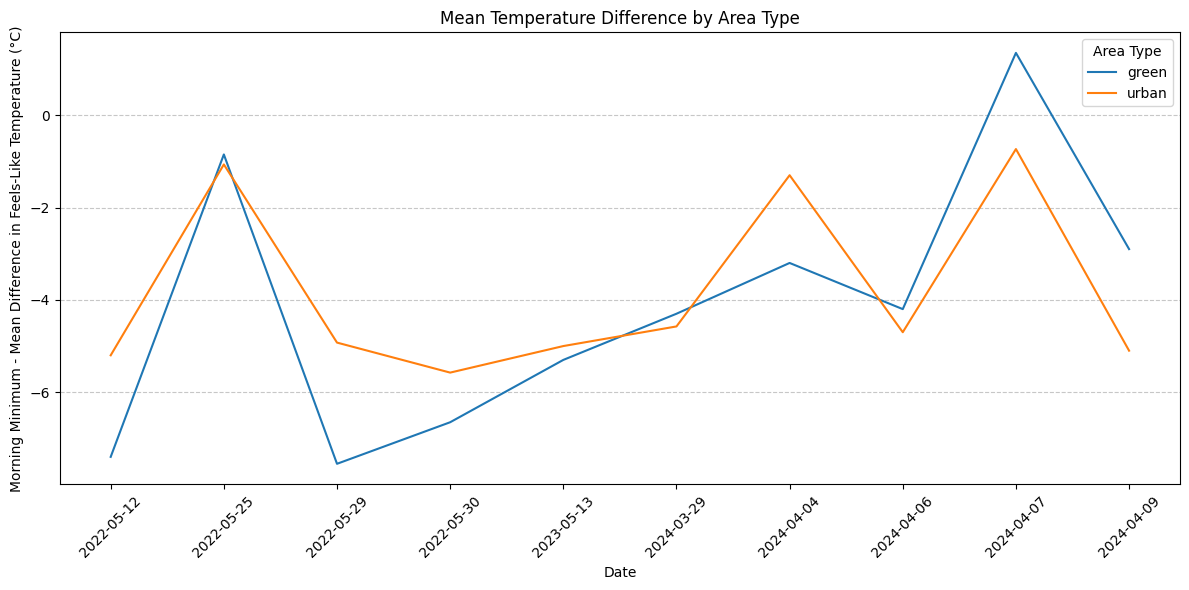

In [ ]:
morning_minimum_mean = morning_minimum_diff.groupby(level='area_type').mean()
morning_minimum_mean = morning_minimum_mean.T

plt.figure(figsize=(12, 6))
for area_type in morning_minimum_mean.columns:
    plt.plot(morning_minimum_mean.index, morning_minimum_mean[area_type], label=area_type)

plt.xlabel('Date')
plt.ylabel('Morning Minimum - Mean Difference in Feels-Like Temperature (°C)')
plt.title('Mean Temperature Difference by Area Type')
plt.legend(title='Area Type')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()